In [1]:
#!pip install pandas numpy matplotlib nltk scikit-learn
#!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.utils import resample
from wordcloud import WordCloud

In [3]:
# COURS 4
data_path = "../../figures/nyt_data.csv"
df = pd.read_csv(data_path, delimiter=",")
print(df.head())

                                                LINK  \
0  https://www.nytimes.com/2024/03/22/business/ar...   
1  https://www.nytimes.com/2024/03/20/world/middl...   
2  https://www.nytimes.com/2024/03/21/science/arc...   
3  https://www.nytimes.com/2024/03/20/world/asia/...   
4  https://www.nytimes.com/2024/03/22/world/austr...   

                                               TITLE  \
0  The A.I. Boom Makes Millions for an Unlikely I...   
1       Israel-Hamas War in Gaza Leaves Power Vacuum   
2  Long Before Amsterdam’s Coffee Shops, There We...   
3            Thursday Briefing: Where is Gaza’s Aid?   
4  What We Gained (and Lost) When Our Daughter Un...   

                                         DESCRIPTION  \
0  The small Caribbean territory brought in $32 m...   
1  Analysts say the Israeli military’s return to ...   
2  A nearly 2,000-year-old stash pouch provides t...   
3  Also, sweeping U.S. climate regulations and th...   
4  My 13-year-old has left her phone behind fo

In [4]:
# On calcule la longueur de notre corpus
def calculate_lengths(corpus):
    """
    Cette fonction permet de calculer la longueur de chaque texte dans un corpus en nombre de mots.

    Paramètres:
    corpus (str): Notre corpus sous dataframe (Pandas).

    Retourne:
    corpus : Notre corpus retourné qui contenient la longueur de chaque texte en nombre de mots.

    Notre fonction utilise la tokenisation pour diviser chaque texte en mots, puis calcule et retourne le nombre de mots pour chaque texte
    du corpus.
    """
    # Ici, on utilise une fonction lambda pour découper chaque texte en mots et calculer le nombre de mots dans chaque texte
    return corpus.apply(lambda x: len(word_tokenize(x)))
    # apply() permet d'appliquer une fonction sur les éléments de notre dataframe --> notre corpus

In [5]:
# On veut éliminer les outliers
def remove_outliers(text_lengths, threshold=3):
    """
    Cette fonction élimine 'les valeurs aberrantes' dans les longueurs des textes en fonction d'un seuil donné.

    Paramètres:
    text_lengths (str): Le dataframe retourné contenant les longueurs des textes.
    threshold (int): Le nombre d'écarts-types à utiliser pour déterminer le seuil des valeurs aberrantes. Par défaut, il est fixé à 3.

    Retourne:
    On retourne notre dataframe avec les longueurs des textes filtrées, sans les valeurs aberrantes.
    """
    # On calcule la moyenne et l'écart-type des longueurs des textes
    mean = np.mean(text_lengths)
    std_dev = np.std(text_lengths)

    # On filtre les longueurs des textes ( < ou = ou à la moyenne : + 3 fois de l'écart-type). Donc on garde uniquement ce qui est raisonnable
    filtered_lengths = text_lengths[text_lengths <= mean + threshold * std_dev]
    return filtered_lengths

In [6]:
# On veut extraire les stopword : les mots les plus fréquents
def extract_frequency(corpus, n=10):
    """
    Cette fonction permet d'extraire les mots les plus fréquents dans un corpus de textes après avoir enlevé les stopwords.

    Paramètres:
    corpus (list de str): Notre liste de chaînes de caractères représentant les textes du corpus.
    n (int, optionnel): Le nombre de mots les plus fréquents à retourner. Par défaut, il est fixé à 10.

    Retourne:
    list of tuple: Une liste de tuples contenant les mots les plus fréquents et leur fréquence, triée par fréquence décroissante.

    Cette fonction permet de : 
    - concatener tous les textes du corpus en une seule chaîne de caractères,
    - convertire le texte en minuscules,
    - tokeniser le texte en mots,
    - enlever les stopwords anglais, 
    - calculer et retourner les n mots les plus fréquents avec leur fréquence.
    """
    # On veut qu'une chaine de caractère donc on concatène on joignant tous les texte du corpus en miniscule
    all_words = " ".join(corpus).lower()

    tokenizer = RegexpTokenizer(
        r"\w+"
    )  # On utilise un tokenizer pour diviser la chaîne de caractères en mots (regex)
    words = tokenizer.tokenize(all_words)

    stop_words = set(
        stopwords.words("english")
    )  # notre corpus vient de NYT, donc on choisit les stopwords de l'anglais
    filtered_words = [
        word for word in words if word not in stop_words
    ]  # On enlève les stopwords !

    # On calcule la fréquence des mots restants
    freq_dist = FreqDist(filtered_words)
    frequent_words = freq_dist.most_common(n)  # selection des n mots plus fréquents
    return frequent_words

In [7]:
# On equilibre les classes en augmentant les données
def augment_data(corpus, target):
    """
    Cette fonction permet d'augmenter les données du corpus pour équilibrer les classes en répétant les textes jusqu'à atteindre une taille
    cible.

    Paramètres:
    corpus (list de str): Toujours notre liste de chaînes de caractères qui représentent tous les textes de notre corpus.
    target (int): La taille cible du corpus augmenté.

    Retourne:
    On retorune de nouveau notre liste de chaînes de caractères qui représentent le corpus augmenté.
    """
    augmented_corpus = []

    # On parcourt chaque texte dans notre corpus
    for text in corpus:

        # Tant que la taille du corpus augmenté est inférieure à la taille cible, on ajouute le texte actuel au corpus augmenté
        while len(augmented_corpus) < target:
            augmented_text = text  # l'augmentation de données
            augmented_corpus.append(augmented_text)
    return augmented_corpus

In [8]:
# On réduit les données
def reduction(corpus, target):
    """
    On veut réduire la taille du corpus à un nombre cible de textes en effectuant un échantillonnage aléatoire.

    Paramètres:
    corpus (str): Toujours notre corpus.
    target (int): La taille cible du corpus réduit.

    Retourne:
    On obtient une liste de chaînes de caractères représentant le corpus réduit.
    """
    reduced_corpus = resample(corpus, replace=False, n_samples=target)
    return reduced_corpus

In [9]:
# La visualisation de la distribution de la longueur
def visualize_lengths(text_lengths):
    """
    Cette fonction permet de visualiser la distribution des longueurs des textes avec des barres colorées en fonction de la longueur normalisée.

    Paramètres:
    text_lengths (int): Notre dataframe contenant les longueurs des textes.

    Ainsi, on créé un graphique en barres pour visualiser la distribution des longueurs des textes.
    """
    plt.figure(
        figsize=(12, 6)
    )  # affiche la figure d'une taille adapté car beaucoup d'index
    cmap = plt.get_cmap("plasma")  # sélection de la colormap plasma (+ jolie)

    # On veut que les barres soit coloriées en fonction de la longueur normalisé !
    normalized_lengths = (text_lengths - np.min(text_lengths)) / (
        np.max(text_lengths) - np.min(text_lengths)
    )
    colors = cmap(normalized_lengths)

    plt.bar(range(len(text_lengths)), text_lengths, color=colors, alpha=0.7)
    plt.xlabel("L'index de notre corpus")
    plt.ylabel("La longueur de nos textes")
    plt.title("La distribution des longueurs des textes")
    plt.show()

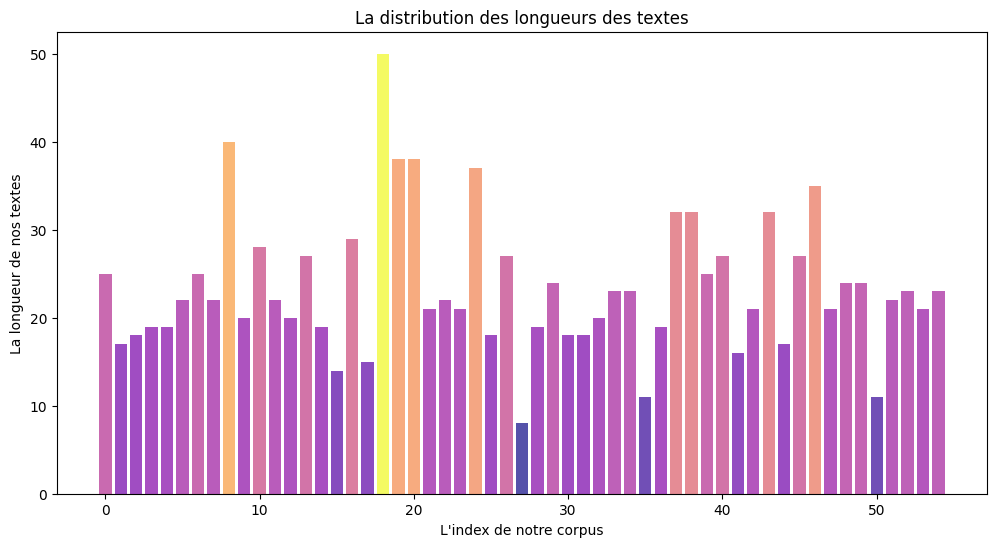

None


In [10]:
# On calcule et on visualise la longueur des textes
text_lengths = calculate_lengths(df["CONTENT"])
print(visualize_lengths(text_lengths))

In [11]:
# Ici on élimine les outliers
filtered_lengths = remove_outliers(text_lengths)
print("La longueur des textes après la suppression des 'outliers' :", filtered_lengths)

La longueur des textes après la suppression des 'outliers' : 0     25
1     17
2     18
3     19
4     19
5     22
6     25
7     22
8     40
9     20
10    28
11    22
12    20
13    27
14    19
15    14
16    29
17    15
19    38
20    38
21    21
22    22
23    21
24    37
25    18
26    27
27     8
28    19
29    24
30    18
31    18
32    20
33    23
34    23
35    11
36    19
37    32
38    32
39    25
40    27
41    16
42    21
43    32
44    17
45    27
46    35
47    21
48    24
49    24
50    11
51    22
52    23
53    21
54    23
Name: CONTENT, dtype: int64


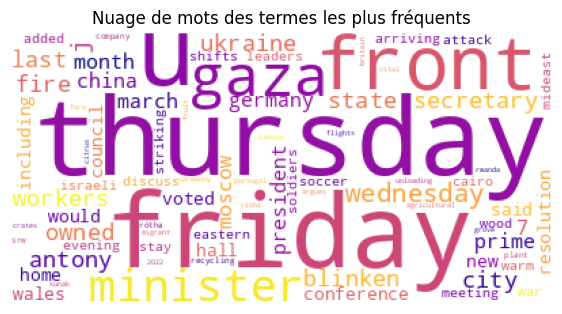

In [12]:
# NUAGE DE MOT
# On extrait et affiche les 100 mots les plus fréquents
frequent_words = extract_frequency(df["CONTENT"], n=80)

# On met les mots et fréquences dans un dictionnaire
frequent_words_dict = dict(frequent_words)

# Générer le nuage de mots avec Wordcloud !
wordcloud = WordCloud(
    background_color="white", colormap="plasma"
).generate_from_frequencies(frequent_words_dict)

# Afficher le nuage de mots
plt.figure(figsize=(7, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Nuage de mots des termes les plus fréquents")
plt.show()

# Afficher sans visualisation :
# On extrait et affiche les mots les plus fréquents
# frequent_words = extract_frequency(df["CONTENT"])
# print("Les mots les plus fréquents :", frequent_words)

In [13]:
# A la fin on équilibrer les classes en réduisant les données sinon on affiche un message d'erreur
target = 20  # Notre taille pour cibler la classe après réduction
if target <= len(df["CONTENT"]):
    reduced = reduction(df["CONTENT"], target)
    print("La taille de la classe après réduction :", len(reduced))
else:
    print("Malheureusement, la taille est supérieure au nombre total")

La taille de la classe après réduction : 20
